# Denoising experiments

## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn

## Step 1: Data Analysis

In [ ]:
df = pd.read_csv("OpenBCI-RAW.txt", comment='%')
df = df.rename(columns=lambda x: x.strip())
df = df[5:]
df.head()

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8,...,Other.3,Other.4,Other.5,Other.6,Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Other.7,Timestamp (Formatted)
5,6.0,60097.470593,63373.498723,-30929.204038,-2449.259454,17784.076069,9420.790901,28911.824991,4166.231056,33888.016211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.702
6,8.0,60103.214991,63383.400546,-30918.229332,-2395.458805,17784.970139,9449.512893,28909.790982,4172.154268,33891.391324,...,15.5,48.0,3.0,104.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.710
7,10.0,60103.013826,63379.265473,-30916.977634,-2425.164273,17783.964310,9441.689782,28909.813334,4172.310730,33902.075458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.718
8,12.0,60108.221782,63382.618234,-30913.222541,-2382.695959,17795.654273,9439.745181,28930.667511,4179.083309,33905.584682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.726
9,14.0,60104.354930,63375.599787,-30920.822134,-2410.725046,17791.988586,9438.806407,28925.034872,4171.573123,33920.739164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.735


In [ ]:
df.columns

Index(['Sample Index', 'EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2',
       'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6',
       'EXG Channel 7', 'EXG Channel 8', 'EXG Channel 9', 'EXG Channel 10',
       'EXG Channel 11', 'EXG Channel 12', 'EXG Channel 13', 'EXG Channel 14',
       'EXG Channel 15', 'Accel Channel 0', 'Accel Channel 1',
       'Accel Channel 2', 'Other', 'Other.1', 'Other.2', 'Other.3', 'Other.4',
       'Other.5', 'Other.6', 'Analog Channel 0', 'Analog Channel 1',
       'Analog Channel 2', 'Timestamp', 'Other.7', 'Timestamp (Formatted)'],
      dtype='object')

In [ ]:
def plot_eeg(data, figsize=(20, 15), title=None):
    if isinstance(data, torch.Tensor):
        data = data.detach().numpy()

    num_plots = data.shape[1]

    fig, ax = plt.subplots(num_plots, 1, figsize=figsize)
    x = range(len(data))

    if data.ndim == 1:
        data = data[:, None]

    if num_plots == 1:
        ax = [ax]
        # data = data.reshape(1, -1)

    for i in range(num_plots):
        ax[i].plot(x, data[:, i], linewidth=0.5)
        ax[i].set_xlabel("Iter")
        ax[i].set_ylabel("Voltage ($\mu V$)")
        if title:
            ax[i].set_title(title)
        else:
            ax[i].set_title(df.columns[start_idx+i])

    plt.tight_layout()
    plt.show()

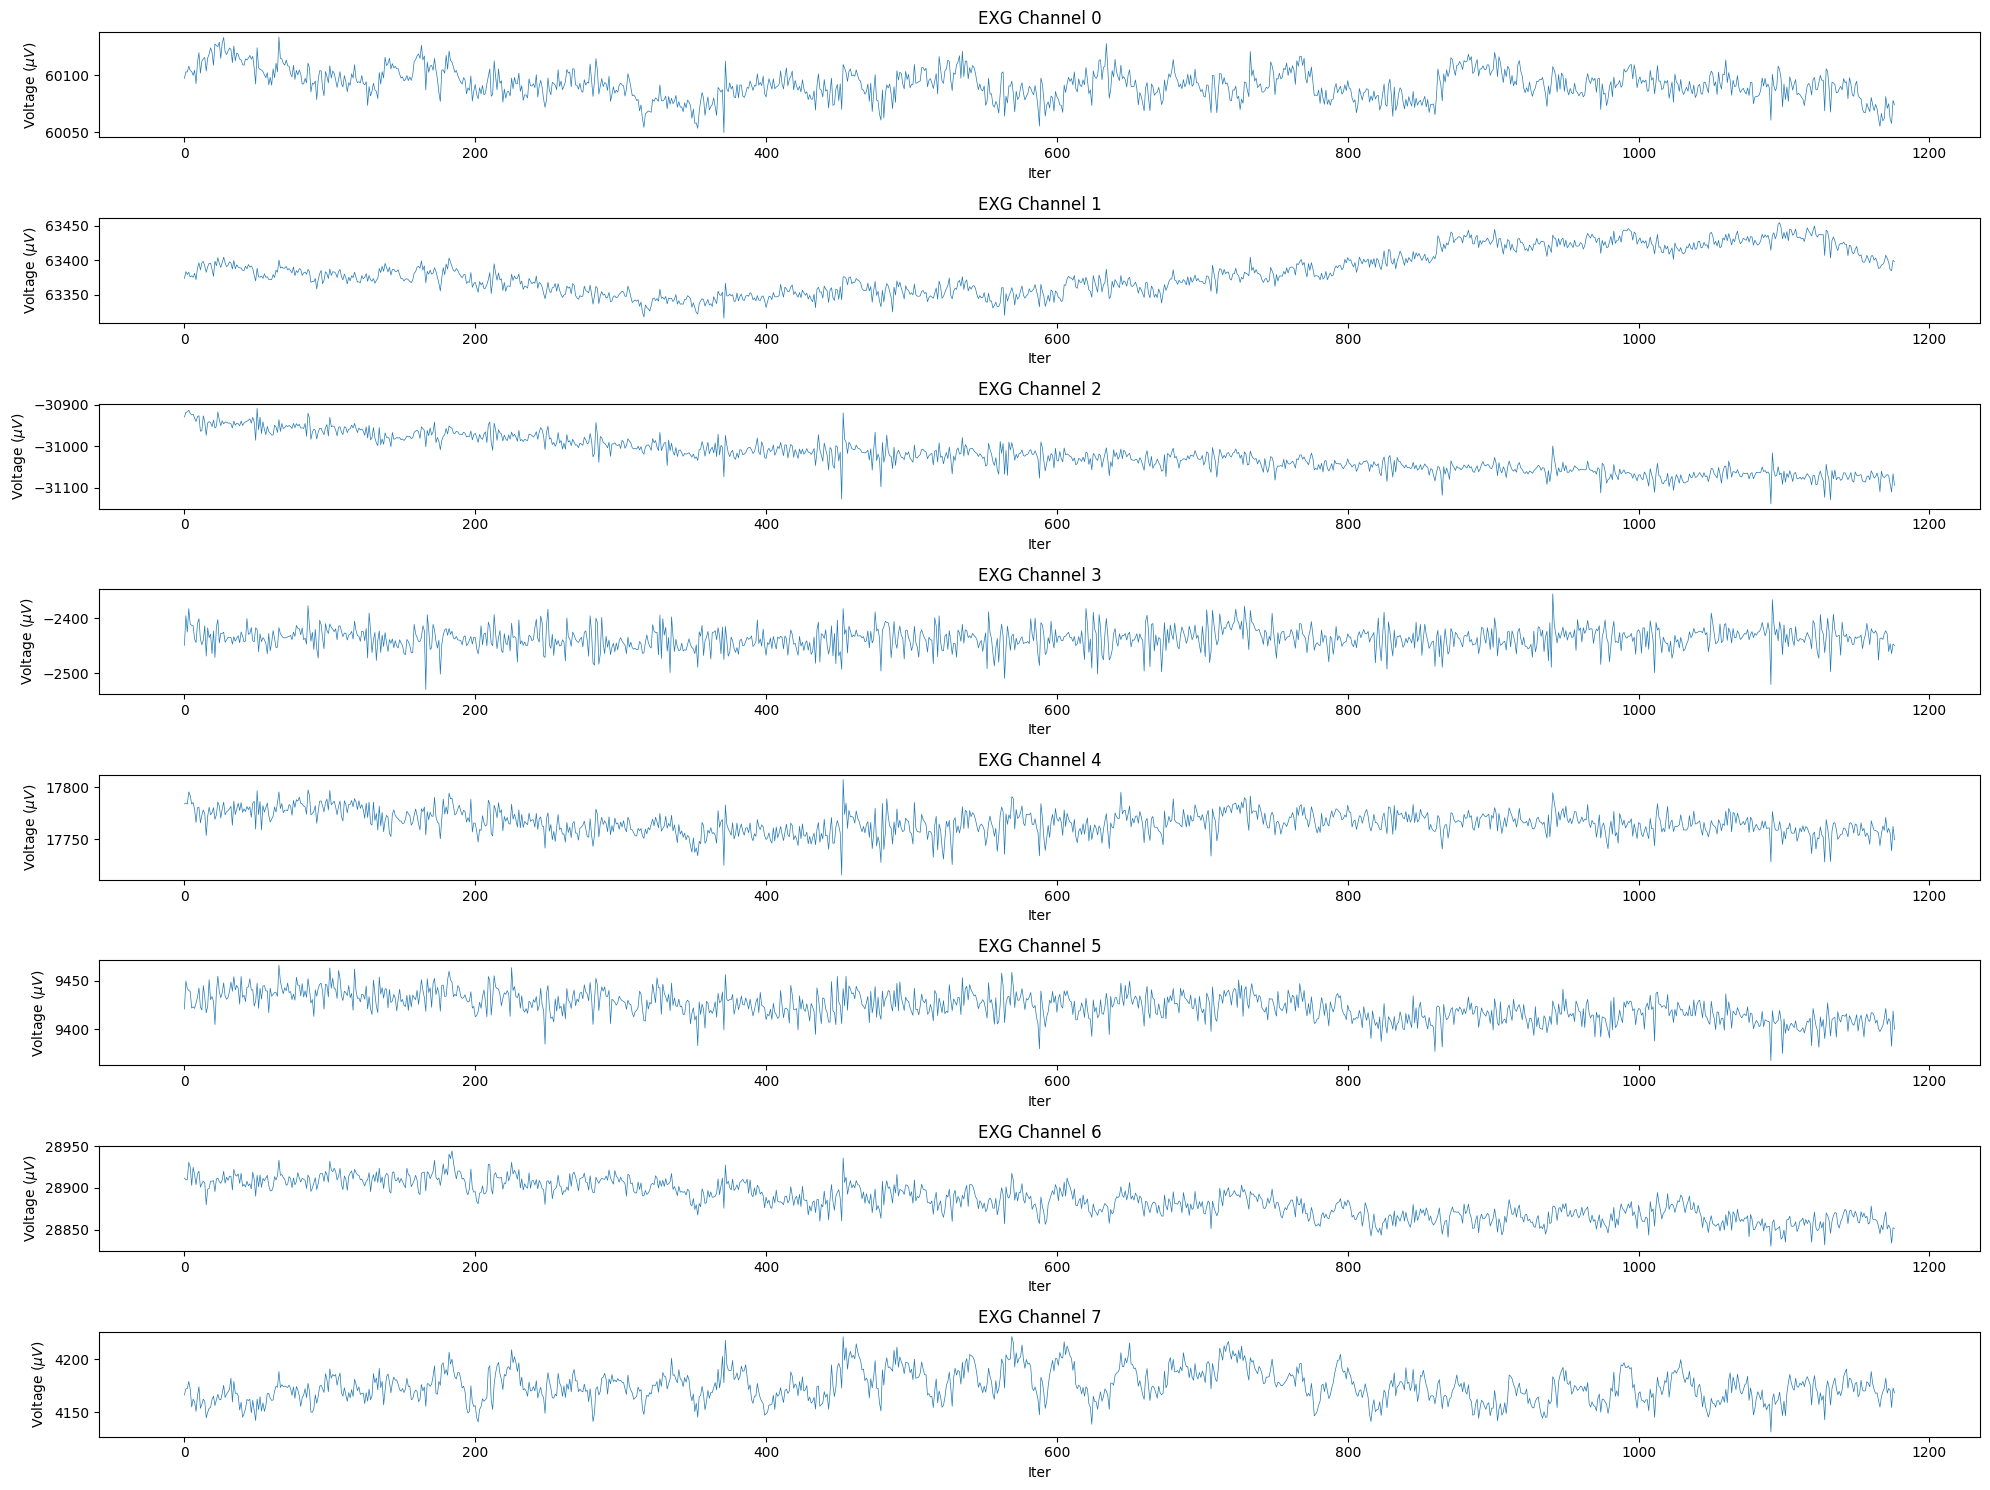

In [ ]:
start_idx = 1
end_idx = start_idx + 8
raw_data = df.iloc[:, start_idx:end_idx].to_numpy()
plot_eeg(raw_data)

## 1. 1D Convolutions

In [ ]:
data_conv_df = df.iloc[:, 1]
data_conv_df.head()

5    60097.470593
6    60103.214991
7    60103.013826
8    60108.221782
9    60104.354930
Name: EXG Channel 0, dtype: float64

In [ ]:
data_conv = torch.tensor(data_conv_df.to_numpy(), dtype=torch.float32).view(1, 1, -1)

In [ ]:
class ConvolutionNoiseReductor(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(ConvolutionNoiseReductor, self).__init__()
        self.conv = nn.Conv1d(1, 1, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
model = ConvolutionNoiseReductor(kernel_size=256, stride=16)

result = model(data_conv)

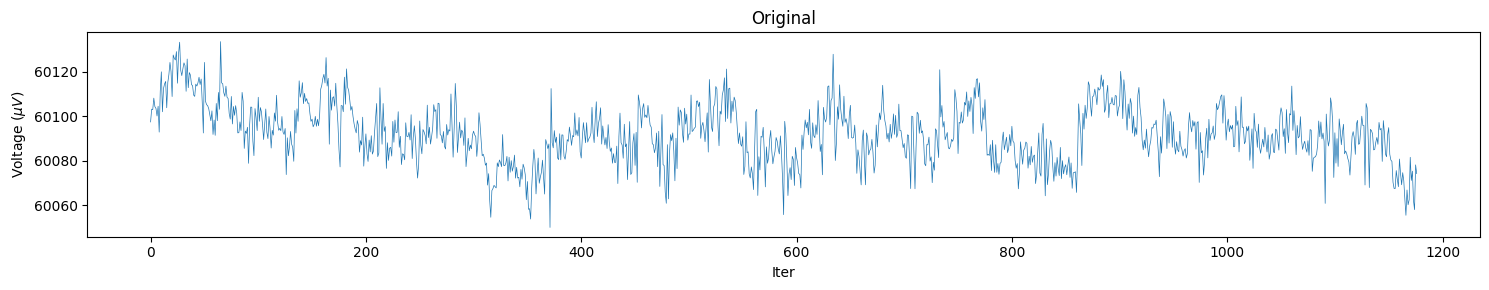

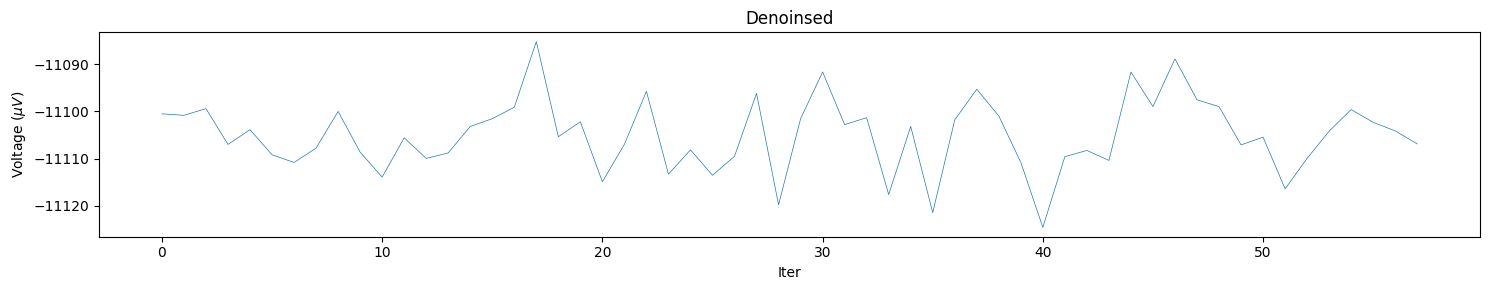

In [ ]:
plot_eeg(df["EXG Channel 0"].to_numpy()[..., np.newaxis], figsize=(15, 3), title="Original")
plot_eeg(result[0, :, :].T, figsize=(15, 3), title="Denoinsed")

**Convolutions ❌** \\
One major flaw of using convolutions for EEG signal denoising is that the values have a very large shift after applying the convolution.

## 2. ICA

In [ ]:
!pip install -q mne

In [ ]:
import mne
from mne.preprocessing import ICA

In [ ]:
data_ica_df = df.iloc[:, 1:10]
data_ica_df.head()

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8
5,-2.263814e-15,63373.498723,-30929.204038,-2449.259454,17784.076069,9420.790901,28911.824991,4166.231056,33888.016211
6,5.169771e+00,63383.400546,-30918.229332,-2395.458805,17784.970139,9449.512893,28909.790982,4172.154268,33891.391324
7,4.414560e+00,63379.265473,-30916.977634,-2425.164273,17783.964310,9441.689782,28909.813334,4172.310730,33902.075458
8,9.073675e+00,63382.618234,-30913.222541,-2382.695959,17795.654273,9439.745181,28930.667511,4179.083309,33905.584682
9,4.654758e+00,63375.599787,-30920.822134,-2410.725046,17791.988586,9438.806407,28925.034872,4171.573123,33920.739164


In [ ]:
sfreq = 100
info = mne.create_info(ch_names=data_ica_df.columns.tolist(), sfreq=sfreq, ch_types='eeg')

raw = mne.io.RawArray(data_ica_df.T.values, info)

ica = ICA(n_components=None, random_state=42, max_iter=800)
raw.filter(l_freq=1.0, h_freq=None)
ica.fit(raw)

Creating RawArray with float64 data, n_channels=9, n_times=1177
    Range : 0 ... 1176 =      0.000 ...    11.760 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 s)

Fitting ICA to data using 9 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 9 components
Fitting ICA took 0.2s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,28 iterations on raw data (1177 samples)
ICA components,9
Available PCA components,9
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
ica.apply(raw)
denoised_df = pd.DataFrame(raw.get_data().T, columns=data_ica_df.columns.tolist())
denoised_df.head()

Applying ICA to Raw instance
    Transforming to ICA space (9 components)
    Zeroing out 0 ICA components
    Projecting back using 9 PCA components


,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8
0,-5.629982e-16,1.574826e-11,6.139632e-12,-8.743945e-13,4.008169e-12,8.604166e-13,3.611148e-12,1.045784e-12,5.731555e-12
1,5.143647e+00,9.667687e+00,1.136405e+01,5.345998e+01,9.853559e-01,2.836967e+01,-1.977089e+00,5.962396e+00,1.312395e+01
2,4.365187e+00,5.300093e+00,1.301094e+01,2.343359e+01,7.318046e-02,2.020001e+01,-1.894789e+00,6.160355e+00,3.355549e+01
3,9.001663e+00,8.421926e+00,1.715991e+01,6.557476e+01,1.185596e+01,1.790875e+01,1.901881e+01,1.297502e+01,4.680568e+01
4,4.559451e+00,1.172478e+00,9.952692e+00,3.721300e+01,8.281158e+00,1.662263e+01,1.344111e+01,5.504396e+00,7.169148e+01


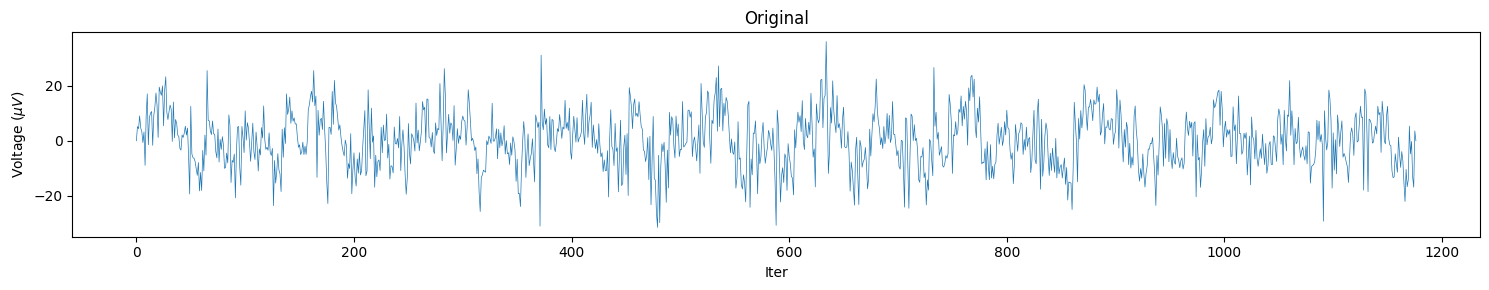

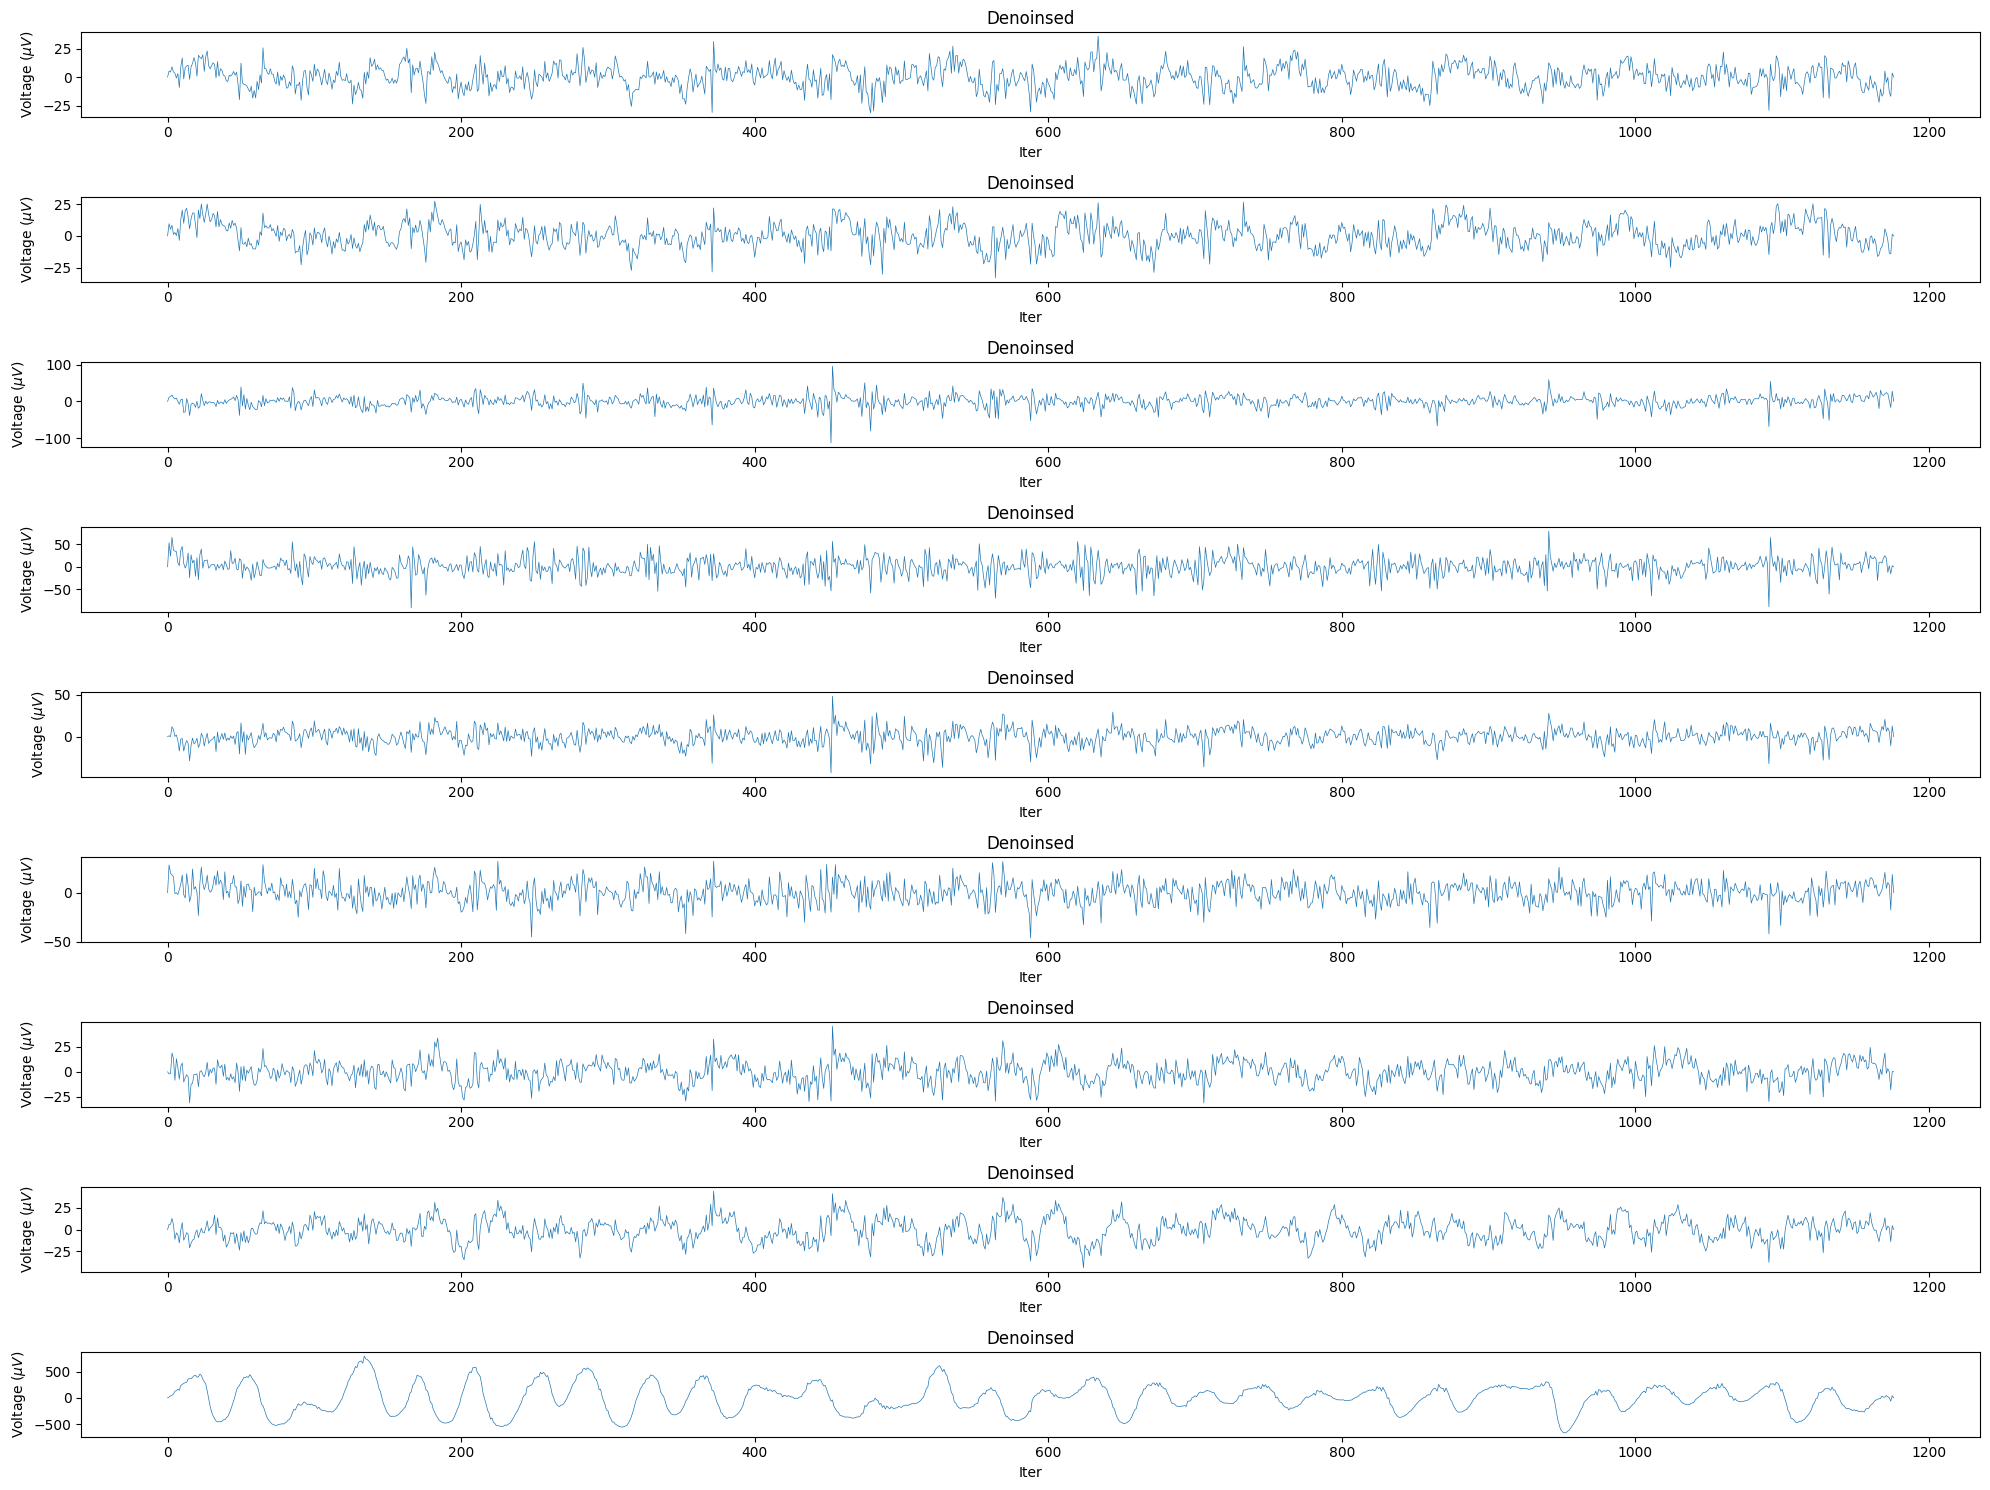

In [ ]:
plot_eeg(df["EXG Channel 0"].to_numpy()[..., np.newaxis], figsize=(15, 3), title="Original")
plot_eeg(denoised_df.to_numpy(), title="Denoinsed")